# Imports

In [1]:
#Pandas, Numpy importieren
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sl
import scipy.stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

#Importeieren der Modelle aus verschiedenen Bibliotheken
from sklearn.linear_model import LinearRegression
from statsmodels.regression.linear_model import GLS
from linearmodels.panel import PooledOLS


# Splitting data into training and testing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.model_selection import train_test_split

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None

# Display up to 60 columns of a dataframe
pd.set_option('display.max_columns', 600)

# Matplotlib visualization
%matplotlib inline
# Set default font size
plt.rcParams['font.size'] = 24

# Internal ipython tool for setting figure size
from IPython.core.pylabtools import figsize
#figsize(6, 6)

# Seaborn for visualization
sns.set(font_scale = 2)

# Import der Daten

In [2]:
pd.set_option('display.max_columns', 600)

data = pd.read_csv('../../data/science_imputed_2.csv')
data = data.sample(frac=1)

#data.info()
#data.head()

# Benötigte Funktionen

## Methode zur Modellierung

In [3]:
'''
Params:  
    target: Variable, die vorhergesagt werden soll
    pexog_vars: liste der exogenen Variablen Bsp.: ['GINI', "log(GDP)", "HDI", "TIME", "LOCATION"]
    pX: Datensatz, auf dem die Kreuzvalidierung durchgeführt werden soll
    
'''

def modellieren(pexog_vars, pX, target):
    exog_vars = pexog_vars
    exog = sm.add_constant(pX[exog_vars])
    # data = data.drop(columns={"LOCATION", "TIME", "SUBJECT"})

    mod = PooledOLS(target, exog)

    pooled_res = mod.fit(cov_type='clustered', clusters=pX.LOCATION)
    
    r2_adj = (1-(((1 - pooled_res.rsquared)*(target.shape[0] - 1))/(target.shape[0]-(len(pexog_vars))-1)))
    print("R^2 adj.: ", r2_adj)
    
    return pooled_res

## Kreuzvalidierung

Die Kreuzvalidierung wird durchgeführt mit einer K-Fold Kreuzvalidierung. 

In [4]:
'''
Params: 
    n_splits: Anzahl der folds 
    target
    pexog_vars: liste der exogenen Variablen Bsp.: ['GINI', "log(GDP)", "HDI", "TIME", "LOCATION"]
    pX: Datensatz, auf dem die Kreuzvalidierung durchgeführt werden soll
    
'''



def k_fold_pooledOLS(n_splits, target, pexog_vars, pX):
    
#     #
#     exog_vars = pexog_vars.append("LOCATION", "TIME")
    features = pX
    
    
    # Splitten in der Reihenfolge der Reihen im df
    kf = KFold(n_splits, shuffle=True)
    r2 = np.zeros(n_splits)
    rmse = np.zeros(n_splits)
    r2_adj = np.zeros(n_splits)
    # print(r2)
    i=0

    for train_index, val_index in kf.split(features):
    #     print("%s %s" % (train_index, test_index))
        X_train, X_validate, y_train, y_validate = features.iloc[train_index], features.iloc[val_index], target.iloc[train_index], target.iloc[val_index]
        #print(X_train)
        
#         print(X_train)
        
        r2[i], rmse[i], r2_adj[i] = prediction(pexog_vars, X_train, y_train, X_validate,  y_validate)

    #     print(r2[i])
        i = i+1

    print("--------------------------- TOTAL ---------------------------------")
    print("R^2s: ", r2)
    # calculate mean of metrics
    print("R^2 mean: ", r2.mean())
    print("R^2 std: ", r2.std())
    
    print("\nR^2 adj.: ", r2_adj)
    # calculate mean of metrics
    print("R^2 adj. mean: ", r2_adj.mean())
    print("R^2 adj. std: ", r2_adj.std())
    
    print("\nRMSEs: ", rmse)
    # calculate mean of metrics
    print("RMSE mean: ", rmse.mean())
    print("RMSE std: ", rmse.std())

## Modell Vorhersage

In [5]:
'''
Params: 
    pexog_vars: liste der exogenen Variablen Bsp.: ['GINI', "log(GDP)", "HDI", "TIME", "LOCATION"]
    pX: 
    y_test: Y Werte des Testdatensatzes
    
'''



'''
R^2 ist NICHT out of sample => es ist das R^2 für das Modell auf den Trainingsdaten
R^2 ajd. ist NICHT out of sample => es ist das R^2 adj. für das Modell auf den Trainingsdaten
RSME ist out of sample => es ist das RMSE für das Modell auf den Testdaten
'''

def prediction(pexog_vars, pX, py, pX_test, py_test):

    #pX enthält Loaction Time Subejct
    exog = sm.add_constant(pX[pexog_vars])
    
#     print(py, exog)
    mod = PooledOLS(py, exog)

    pooled_res = mod.fit(cov_type='clustered', clusters=pX.LOCATION)
    #print(mod.predict(params=pooled_res.params, exog=X_test))
    
    
    # Prediction y^= X_test * beta
    x_pred = np.array(sm.add_constant(pX_test[pexog_vars]))
    
    b_pred = np.array(pooled_res.params)[0:len(pexog_vars)+1]

    y_pred = x_pred.dot(b_pred) 
    #print(y_pred)
    #print('\n')
    
    y_test = np.array(py_test)
    #print(y_test)
#     print('\n')
    squares = (y_pred-py_test)**2
    mse = (1/y_pred.shape[0])*(np.sum(squares))
    
#     print('Anzahl exogene Variablen: ', len(pexog_vars))
#     print('Anzahl Beobachtungen: ', y_pred.shape[0])
#     print('\n')
#     r2 = 1 - RSS/TSS
#     RSS = (np.sum(squares)
    
    # r^2 adj in-sample calculation
    r2_adj = (1-(((1 - pooled_res.rsquared)*(py.shape[0] - 1))/(py.shape[0]-(len(pexog_vars))-1)))
    
    
    ### 
   
    print('\nR^2 = ', pooled_res.rsquared)
    print('R^2 adj. = ', r2_adj)
#     print("MSE = ", mse)
    print("RMSE = ", np.sqrt(mse))
    
    return pooled_res.rsquared, np.sqrt(mse), r2_adj

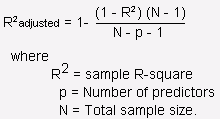

# Aufteilung der Daten in Train- & Testdatensatz

In [6]:
time = pd.Categorical(data["TIME"])
location = pd.Categorical(data["LOCATION"])
data = data.set_index(['LOCATION', 'TIME'])
data['TIME'] = time
data['LOCATION'] = location
# print(data)

features = data.drop(["PISA Science", "SUBJECT"], axis=1)
#PISA Math
X, X_test, y, y_test = train_test_split(features, data["PISA Science"], test_size = 0.1, random_state = 42)

#Festlegung der Parameter für die Modellierung methode
pX = X
target = y



# Null Modell

In [7]:
pexog_vars = []

modellieren(pexog_vars, pX, target)

R^2 adj.:  -2.220446049250313e-16


Dep. Variable:,PISA Science,R-squared:,-2.22e-16
Estimator:,PooledOLS,R-squared (Between):,0.0000
No. Observations:,176,R-squared (Within):,0.0000
Date:,"Mon, Feb 01 2021",R-squared (Overall):,0.0000
Time:,22:00:58,Log-likelihood,-884.27
Cov. Estimator:,Clustered,,
,,F-statistic:,--
Entities:,44,P-value,--
Avg Obs:,4.0000,Distribution:,--
Min Obs:,1.0000,,
Max Obs:,5.0000,F-statistic (robust):,--


# 1. Regressor

### Gini-Koeffizient

In [8]:
pexog_vars = ['GINI']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.41473626154167


Dep. Variable:,PISA Science,R-squared:,0.4181
Estimator:,PooledOLS,R-squared (Between):,0.5135
No. Observations:,176,R-squared (Within):,-0.2535
Date:,"Mon, Feb 01 2021",R-squared (Overall):,0.4181
Time:,22:00:58,Log-likelihood,-836.62
Cov. Estimator:,Clustered,,
,,F-statistic:,125.01
Entities:,44,P-value,0.0000
Avg Obs:,4.0000,Distribution:,"F(1,174)"
Min Obs:,1.0000,,
Max Obs:,5.0000,F-statistic (robust):,33.787


### BIP

In [9]:
pexog_vars = ['log(GDP)']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.34659270959835276


Dep. Variable:,PISA Science,R-squared:,0.3503
Estimator:,PooledOLS,R-squared (Between):,0.5208
No. Observations:,176,R-squared (Within):,-1.4014
Date:,"Mon, Feb 01 2021",R-squared (Overall):,0.3503
Time:,22:00:58,Log-likelihood,-846.31
Cov. Estimator:,Clustered,,
,,F-statistic:,93.827
Entities:,44,P-value,0.0000
Avg Obs:,4.0000,Distribution:,"F(1,174)"
Min Obs:,1.0000,,
Max Obs:,5.0000,F-statistic (robust):,14.741


### CPI

In [10]:
pexog_vars = ['CPI']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.40368335373192166


Dep. Variable:,PISA Science,R-squared:,0.4071
Estimator:,PooledOLS,R-squared (Between):,0.4646
No. Observations:,176,R-squared (Within):,-0.0985
Date:,"Mon, Feb 01 2021",R-squared (Overall):,0.4071
Time:,22:00:58,Log-likelihood,-838.27
Cov. Estimator:,Clustered,,
,,F-statistic:,119.47
Entities:,44,P-value,0.0000
Avg Obs:,4.0000,Distribution:,"F(1,174)"
Min Obs:,1.0000,,
Max Obs:,5.0000,F-statistic (robust):,23.989


### Anteil der 25-64 jährigen mit tertiärer Bildung

In [11]:
pexog_vars = ['log(PCT_EDU_TRY)']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.4257007730201967


Dep. Variable:,PISA Science,R-squared:,0.4290
Estimator:,PooledOLS,R-squared (Between):,0.4952
No. Observations:,176,R-squared (Within):,-1.3215
Date:,"Mon, Feb 01 2021",R-squared (Overall):,0.4290
Time:,22:00:59,Log-likelihood,-834.96
Cov. Estimator:,Clustered,,
,,F-statistic:,130.72
Entities:,44,P-value,0.0000
Avg Obs:,4.0000,Distribution:,"F(1,174)"
Min Obs:,1.0000,,
Max Obs:,5.0000,F-statistic (robust):,26.617


### Migration

In [12]:
pexog_vars = ['log(MIGRANTS)']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.37478679362818135


Dep. Variable:,PISA Science,R-squared:,0.3784
Estimator:,PooledOLS,R-squared (Between):,0.4758
No. Observations:,176,R-squared (Within):,-0.1446
Date:,"Mon, Feb 01 2021",R-squared (Overall):,0.3784
Time:,22:00:59,Log-likelihood,-842.43
Cov. Estimator:,Clustered,,
,,F-statistic:,105.90
Entities:,44,P-value,0.0000
Avg Obs:,4.0000,Distribution:,"F(1,174)"
Min Obs:,1.0000,,
Max Obs:,5.0000,F-statistic (robust):,19.162


### Mordrate

In [13]:
pexog_vars = ['HOMICIDES']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.3262872520651492


Dep. Variable:,PISA Science,R-squared:,0.3301
Estimator:,PooledOLS,R-squared (Between):,0.3969
No. Observations:,176,R-squared (Within):,-0.4656
Date:,"Mon, Feb 01 2021",R-squared (Overall):,0.3301
Time:,22:00:59,Log-likelihood,-849.01
Cov. Estimator:,Clustered,,
,,F-statistic:,85.755
Entities:,44,P-value,0.0000
Avg Obs:,4.0000,Distribution:,"F(1,174)"
Min Obs:,1.0000,,
Max Obs:,5.0000,F-statistic (robust):,81.734


### Alkohol Konsum pro Kopf

In [14]:
pexog_vars = ['ALC_PC']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.3686350873353522


Dep. Variable:,PISA Science,R-squared:,0.3722
Estimator:,PooledOLS,R-squared (Between):,0.4712
No. Observations:,176,R-squared (Within):,-0.1195
Date:,"Mon, Feb 01 2021",R-squared (Overall):,0.3722
Time:,22:00:59,Log-likelihood,-843.29
Cov. Estimator:,Clustered,,
,,F-statistic:,103.18
Entities:,44,P-value,0.0000
Avg Obs:,4.0000,Distribution:,"F(1,174)"
Min Obs:,1.0000,,
Max Obs:,5.0000,F-statistic (robust):,28.031


### Internet PC

In [15]:
pexog_vars = ['INTERNET_PC']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.2384259989064057


Dep. Variable:,PISA Science,R-squared:,0.2428
Estimator:,PooledOLS,R-squared (Between):,0.3586
No. Observations:,176,R-squared (Within):,-2.9161
Date:,"Mon, Feb 01 2021",R-squared (Overall):,0.2428
Time:,22:00:59,Log-likelihood,-859.79
Cov. Estimator:,Clustered,,
,,F-statistic:,55.787
Entities:,44,P-value,0.0000
Avg Obs:,4.0000,Distribution:,"F(1,174)"
Min Obs:,1.0000,,
Max Obs:,5.0000,F-statistic (robust):,20.194


### Bildungsausgaben im Sekundär Bereich

In [16]:
pexog_vars = ['log(EDU_SPENDING)']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.3421993845011301


Dep. Variable:,PISA Science,R-squared:,0.3460
Estimator:,PooledOLS,R-squared (Between):,0.3686
No. Observations:,176,R-squared (Within):,-0.9364
Date:,"Mon, Feb 01 2021",R-squared (Overall):,0.3460
Time:,22:00:59,Log-likelihood,-846.90
Cov. Estimator:,Clustered,,
,,F-statistic:,92.038
Entities:,44,P-value,0.0000
Avg Obs:,4.0000,Distribution:,"F(1,174)"
Min Obs:,1.0000,,
Max Obs:,5.0000,F-statistic (robust):,23.843


### Schüler, Lehrer Verhältnis

In [17]:
pexog_vars = ['STR_SRY']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.13506002471351541


Dep. Variable:,PISA Science,R-squared:,0.1400
Estimator:,PooledOLS,R-squared (Between):,0.1502
No. Observations:,176,R-squared (Within):,-0.0409
Date:,"Mon, Feb 01 2021",R-squared (Overall):,0.1400
Time:,22:00:59,Log-likelihood,-870.99
Cov. Estimator:,Clustered,,
,,F-statistic:,28.326
Entities:,44,P-value,0.0000
Avg Obs:,4.0000,Distribution:,"F(1,174)"
Min Obs:,1.0000,,
Max Obs:,5.0000,F-statistic (robust):,8.3466


# 2. Regressor

### BIP

In [18]:
pexog_vars = ['log(PCT_EDU_TRY)', 'log(GDP)']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.4542419558441062


Dep. Variable:,PISA Science,R-squared:,0.4605
Estimator:,PooledOLS,R-squared (Between):,0.5805
No. Observations:,176,R-squared (Within):,-1.6287
Date:,"Mon, Feb 01 2021",R-squared (Overall):,0.4605
Time:,22:00:59,Log-likelihood,-829.96
Cov. Estimator:,Clustered,,
,,F-statistic:,73.827
Entities:,44,P-value,0.0000
Avg Obs:,4.0000,Distribution:,"F(2,173)"
Min Obs:,1.0000,,
Max Obs:,5.0000,F-statistic (robust):,17.553


### CPI

In [19]:
pexog_vars = ['log(PCT_EDU_TRY)', 'CPI']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.5178117566883267


Dep. Variable:,PISA Science,R-squared:,0.5233
Estimator:,PooledOLS,R-squared (Between):,0.5917
No. Observations:,176,R-squared (Within):,-0.6529
Date:,"Mon, Feb 01 2021",R-squared (Overall):,0.5233
Time:,22:00:59,Log-likelihood,-819.06
Cov. Estimator:,Clustered,,
,,F-statistic:,94.964
Entities:,44,P-value,0.0000
Avg Obs:,4.0000,Distribution:,"F(2,173)"
Min Obs:,1.0000,,
Max Obs:,5.0000,F-statistic (robust):,22.431


### GINI

In [20]:
pexog_vars = ['log(PCT_EDU_TRY)', 'GINI']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.6240569269632052


Dep. Variable:,PISA Science,R-squared:,0.6284
Estimator:,PooledOLS,R-squared (Between):,0.7281
No. Observations:,176,R-squared (Within):,-1.0154
Date:,"Mon, Feb 01 2021",R-squared (Overall):,0.6284
Time:,22:00:59,Log-likelihood,-797.16
Cov. Estimator:,Clustered,,
,,F-statistic:,146.25
Entities:,44,P-value,0.0000
Avg Obs:,4.0000,Distribution:,"F(2,173)"
Min Obs:,1.0000,,
Max Obs:,5.0000,F-statistic (robust):,55.840


### Migration

In [21]:
pexog_vars = ['log(PCT_EDU_TRY)', 'log(MIGRANTS)']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.48296455552043316


Dep. Variable:,PISA Science,R-squared:,0.4889
Estimator:,PooledOLS,R-squared (Between):,0.5763
No. Observations:,176,R-squared (Within):,-0.8518
Date:,"Mon, Feb 01 2021",R-squared (Overall):,0.4889
Time:,22:00:59,Log-likelihood,-825.21
Cov. Estimator:,Clustered,,
,,F-statistic:,82.734
Entities:,44,P-value,0.0000
Avg Obs:,4.0000,Distribution:,"F(2,173)"
Min Obs:,1.0000,,
Max Obs:,5.0000,F-statistic (robust):,22.202


### Mordrate

In [22]:
pexog_vars = ['log(PCT_EDU_TRY)', 'HOMICIDES']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.577402238499031


Dep. Variable:,PISA Science,R-squared:,0.5822
Estimator:,PooledOLS,R-squared (Between):,0.6715
No. Observations:,176,R-squared (Within):,-1.1600
Date:,"Mon, Feb 01 2021",R-squared (Overall):,0.5822
Time:,22:00:59,Log-likelihood,-807.46
Cov. Estimator:,Clustered,,
,,F-statistic:,120.55
Entities:,44,P-value,0.0000
Avg Obs:,4.0000,Distribution:,"F(2,173)"
Min Obs:,1.0000,,
Max Obs:,5.0000,F-statistic (robust):,155.86


### Alkohol Konsum pro Kopf

In [23]:
pexog_vars = ['log(PCT_EDU_TRY)', 'ALC_PC']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.5973196402366594


Dep. Variable:,PISA Science,R-squared:,0.6019
Estimator:,PooledOLS,R-squared (Between):,0.6738
No. Observations:,176,R-squared (Within):,-0.5479
Date:,"Mon, Feb 01 2021",R-squared (Overall):,0.6019
Time:,22:00:59,Log-likelihood,-803.21
Cov. Estimator:,Clustered,,
,,F-statistic:,130.79
Entities:,44,P-value,0.0000
Avg Obs:,4.0000,Distribution:,"F(2,173)"
Min Obs:,1.0000,,
Max Obs:,5.0000,F-statistic (robust):,24.758


### Internet PC

In [24]:
pexog_vars = ['log(PCT_EDU_TRY)', 'INTERNET_PC']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.42485935315411116


Dep. Variable:,PISA Science,R-squared:,0.4314
Estimator:,PooledOLS,R-squared (Between):,0.5084
No. Observations:,176,R-squared (Within):,-1.6175
Date:,"Mon, Feb 01 2021",R-squared (Overall):,0.4314
Time:,22:01:00,Log-likelihood,-834.58
Cov. Estimator:,Clustered,,
,,F-statistic:,65.637
Entities:,44,P-value,0.0000
Avg Obs:,4.0000,Distribution:,"F(2,173)"
Min Obs:,1.0000,,
Max Obs:,5.0000,F-statistic (robust):,15.346


### Bildungsausgaben im Sekundar Bereich

In [25]:
pexog_vars = ['log(PCT_EDU_TRY)', 'log(EDU_SPENDING)']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.5478650190834442


Dep. Variable:,PISA Science,R-squared:,0.5530
Estimator:,PooledOLS,R-squared (Between):,0.5969
No. Observations:,176,R-squared (Within):,-1.1447
Date:,"Mon, Feb 01 2021",R-squared (Overall):,0.5530
Time:,22:01:00,Log-likelihood,-813.40
Cov. Estimator:,Clustered,,
,,F-statistic:,107.03
Entities:,44,P-value,0.0000
Avg Obs:,4.0000,Distribution:,"F(2,173)"
Min Obs:,1.0000,,
Max Obs:,5.0000,F-statistic (robust):,32.077


### Schüler, Lehrer Verhältnis

In [26]:
pexog_vars = ['log(PCT_EDU_TRY)', 'STR_SRY']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.47422564150164714


Dep. Variable:,PISA Science,R-squared:,0.4802
Estimator:,PooledOLS,R-squared (Between):,0.5372
No. Observations:,176,R-squared (Within):,-1.1440
Date:,"Mon, Feb 01 2021",R-squared (Overall):,0.4802
Time:,22:01:00,Log-likelihood,-826.68
Cov. Estimator:,Clustered,,
,,F-statistic:,79.921
Entities:,44,P-value,0.0000
Avg Obs:,4.0000,Distribution:,"F(2,173)"
Min Obs:,1.0000,,
Max Obs:,5.0000,F-statistic (robust):,16.283


# 3. Regressor

### BIP

In [27]:
pexog_vars = ['log(PCT_EDU_TRY)', 'GINI', 'log(GDP)']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.6233730522947456


Dep. Variable:,PISA Science,R-squared:,0.6298
Estimator:,PooledOLS,R-squared (Between):,0.7205
No. Observations:,176,R-squared (Within):,-0.9501
Date:,"Mon, Feb 01 2021",R-squared (Overall):,0.6298
Time:,22:01:00,Log-likelihood,-796.81
Cov. Estimator:,Clustered,,
,,F-statistic:,97.550
Entities:,44,P-value,0.0000
Avg Obs:,4.0000,Distribution:,"F(3,172)"
Min Obs:,1.0000,,
Max Obs:,5.0000,F-statistic (robust):,37.679


### CPI

In [28]:
pexog_vars = ['log(PCT_EDU_TRY)', 'GINI', 'CPI']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.6477935627233251


Dep. Variable:,PISA Science,R-squared:,0.6538
Estimator:,PooledOLS,R-squared (Between):,0.7422
No. Observations:,176,R-squared (Within):,-0.6787
Date:,"Mon, Feb 01 2021",R-squared (Overall):,0.6538
Time:,22:01:00,Log-likelihood,-790.91
Cov. Estimator:,Clustered,,
,,F-statistic:,108.29
Entities:,44,P-value,0.0000
Avg Obs:,4.0000,Distribution:,"F(3,172)"
Min Obs:,1.0000,,
Max Obs:,5.0000,F-statistic (robust):,38.980


### Migration

In [29]:
pexog_vars = ['log(PCT_EDU_TRY)', 'GINI', 'log(MIGRANTS)']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.6276756767274363


Dep. Variable:,PISA Science,R-squared:,0.6341
Estimator:,PooledOLS,R-squared (Between):,0.7373
No. Observations:,176,R-squared (Within):,-0.8790
Date:,"Mon, Feb 01 2021",R-squared (Overall):,0.6341
Time:,22:01:00,Log-likelihood,-795.80
Cov. Estimator:,Clustered,,
,,F-statistic:,99.340
Entities:,44,P-value,0.0000
Avg Obs:,4.0000,Distribution:,"F(3,172)"
Min Obs:,1.0000,,
Max Obs:,5.0000,F-statistic (robust):,44.506


### Alkohol Konsum pro Kopf

In [30]:
pexog_vars = ['log(PCT_EDU_TRY)', 'GINI', 'ALC_PC']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.6813086392834096


Dep. Variable:,PISA Science,R-squared:,0.6868
Estimator:,PooledOLS,R-squared (Between):,0.7718
No. Observations:,176,R-squared (Within):,-0.5296
Date:,"Mon, Feb 01 2021",R-squared (Overall):,0.6868
Time:,22:01:00,Log-likelihood,-782.11
Cov. Estimator:,Clustered,,
,,F-statistic:,125.71
Entities:,44,P-value,0.0000
Avg Obs:,4.0000,Distribution:,"F(3,172)"
Min Obs:,1.0000,,
Max Obs:,5.0000,F-statistic (robust):,46.114


### Mordrate

In [31]:
pexog_vars = ['log(PCT_EDU_TRY)', 'GINI', 'HOMICIDES']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.6439663775806035


Dep. Variable:,PISA Science,R-squared:,0.6501
Estimator:,PooledOLS,R-squared (Between):,0.7458
No. Observations:,176,R-squared (Within):,-0.9601
Date:,"Mon, Feb 01 2021",R-squared (Overall):,0.6501
Time:,22:01:00,Log-likelihood,-791.86
Cov. Estimator:,Clustered,,
,,F-statistic:,106.51
Entities:,44,P-value,0.0000
Avg Obs:,4.0000,Distribution:,"F(3,172)"
Min Obs:,1.0000,,
Max Obs:,5.0000,F-statistic (robust):,110.78


### Internet PC

In [32]:
pexog_vars = ['log(PCT_EDU_TRY)', 'GINI', 'INTERNET_PC']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.6351375432079087


Dep. Variable:,PISA Science,R-squared:,0.6414
Estimator:,PooledOLS,R-squared (Between):,0.7242
No. Observations:,176,R-squared (Within):,-0.5854
Date:,"Mon, Feb 01 2021",R-squared (Overall):,0.6414
Time:,22:01:00,Log-likelihood,-794.02
Cov. Estimator:,Clustered,,
,,F-statistic:,102.54
Entities:,44,P-value,0.0000
Avg Obs:,4.0000,Distribution:,"F(3,172)"
Min Obs:,1.0000,,
Max Obs:,5.0000,F-statistic (robust):,41.307


### Bildungsausgaben im Sekundar Bereich

In [33]:
pexog_vars = ['log(PCT_EDU_TRY)', 'GINI', 'log(EDU_SPENDING)']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.6563074497558699


Dep. Variable:,PISA Science,R-squared:,0.6622
Estimator:,PooledOLS,R-squared (Between):,0.7365
No. Observations:,176,R-squared (Within):,-0.8371
Date:,"Mon, Feb 01 2021",R-squared (Overall):,0.6622
Time:,22:01:00,Log-likelihood,-788.76
Cov. Estimator:,Clustered,,
,,F-statistic:,112.39
Entities:,44,P-value,0.0000
Avg Obs:,4.0000,Distribution:,"F(3,172)"
Min Obs:,1.0000,,
Max Obs:,5.0000,F-statistic (robust):,41.522


### Schüler, Lehrer Verhältnis

In [34]:
pexog_vars = ['log(PCT_EDU_TRY)', 'GINI', 'STR_SRY']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.622678223940304


Dep. Variable:,PISA Science,R-squared:,0.6291
Estimator:,PooledOLS,R-squared (Between):,0.7309
No. Observations:,176,R-squared (Within):,-1.0413
Date:,"Mon, Feb 01 2021",R-squared (Overall):,0.6291
Time:,22:01:00,Log-likelihood,-796.97
Cov. Estimator:,Clustered,,
,,F-statistic:,97.265
Entities:,44,P-value,0.0000
Avg Obs:,4.0000,Distribution:,"F(3,172)"
Min Obs:,1.0000,,
Max Obs:,5.0000,F-statistic (robust):,37.079


# 4. Regressor

### BIP

In [35]:
pexog_vars = ['log(PCT_EDU_TRY)', 'GINI', 'ALC_PC', 'log(GDP)']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.6810779750413385


Dep. Variable:,PISA Science,R-squared:,0.6884
Estimator:,PooledOLS,R-squared (Between):,0.7651
No. Observations:,176,R-squared (Within):,-0.4711
Date:,"Mon, Feb 01 2021",R-squared (Overall):,0.6884
Time:,22:01:00,Log-likelihood,-781.66
Cov. Estimator:,Clustered,,
,,F-statistic:,94.431
Entities:,44,P-value,0.0000
Avg Obs:,4.0000,Distribution:,"F(4,171)"
Min Obs:,1.0000,,
Max Obs:,5.0000,F-statistic (robust):,34.638


### Mordrate

In [36]:
pexog_vars = ['log(PCT_EDU_TRY)', 'GINI', 'ALC_PC', 'HOMICIDES']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.7196435388335056


Dep. Variable:,PISA Science,R-squared:,0.7261
Estimator:,PooledOLS,R-squared (Between):,0.8071
No. Observations:,176,R-squared (Within):,-0.4911
Date:,"Mon, Feb 01 2021",R-squared (Overall):,0.7261
Time:,22:01:00,Log-likelihood,-770.32
Cov. Estimator:,Clustered,,
,,F-statistic:,113.30
Entities:,44,P-value,0.0000
Avg Obs:,4.0000,Distribution:,"F(4,171)"
Min Obs:,1.0000,,
Max Obs:,5.0000,F-statistic (robust):,88.957


### Migration

In [37]:
pexog_vars = ['log(PCT_EDU_TRY)', 'GINI', 'ALC_PC', 'log(MIGRANTS)']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.6796177297680033


Dep. Variable:,PISA Science,R-squared:,0.6869
Estimator:,PooledOLS,R-squared (Between):,0.7730
No. Observations:,176,R-squared (Within):,-0.5152
Date:,"Mon, Feb 01 2021",R-squared (Overall):,0.6869
Time:,22:01:01,Log-likelihood,-782.07
Cov. Estimator:,Clustered,,
,,F-statistic:,93.806
Entities:,44,P-value,0.0000
Avg Obs:,4.0000,Distribution:,"F(4,171)"
Min Obs:,1.0000,,
Max Obs:,5.0000,F-statistic (robust):,36.975


### CPI

In [38]:
pexog_vars = ['log(PCT_EDU_TRY)', 'GINI', 'ALC_PC', 'CPI']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.711889755684236


Dep. Variable:,PISA Science,R-squared:,0.7185
Estimator:,PooledOLS,R-squared (Between):,0.7943
No. Observations:,176,R-squared (Within):,-0.2650
Date:,"Mon, Feb 01 2021",R-squared (Overall):,0.7185
Time:,22:01:01,Log-likelihood,-772.72
Cov. Estimator:,Clustered,,
,,F-statistic:,109.10
Entities:,44,P-value,0.0000
Avg Obs:,4.0000,Distribution:,"F(4,171)"
Min Obs:,1.0000,,
Max Obs:,5.0000,F-statistic (robust):,34.660


### Internet PC

In [39]:
pexog_vars = ['log(PCT_EDU_TRY)', 'GINI', 'ALC_PC', 'INTERNET_PC']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.6823280156338544


Dep. Variable:,PISA Science,R-squared:,0.6896
Estimator:,PooledOLS,R-squared (Between):,0.7678
No. Observations:,176,R-squared (Within):,-0.3812
Date:,"Mon, Feb 01 2021",R-squared (Overall):,0.6896
Time:,22:01:01,Log-likelihood,-781.32
Cov. Estimator:,Clustered,,
,,F-statistic:,94.971
Entities:,44,P-value,0.0000
Avg Obs:,4.0000,Distribution:,"F(4,171)"
Min Obs:,1.0000,,
Max Obs:,5.0000,F-statistic (robust):,35.544


### Bildungsausgaben im Sekundar Bereich

In [40]:
pexog_vars = ['log(PCT_EDU_TRY)', 'GINI', 'ALC_PC', 'log(EDU_SPENDING)']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.6860013668605789


Dep. Variable:,PISA Science,R-squared:,0.6932
Estimator:,PooledOLS,R-squared (Between):,0.7682
No. Observations:,176,R-squared (Within):,-0.4951
Date:,"Mon, Feb 01 2021",R-squared (Overall):,0.6932
Time:,22:01:01,Log-likelihood,-780.29
Cov. Estimator:,Clustered,,
,,F-statistic:,96.582
Entities:,44,P-value,0.0000
Avg Obs:,4.0000,Distribution:,"F(4,171)"
Min Obs:,1.0000,,
Max Obs:,5.0000,F-statistic (robust):,32.998


### Schüler, Lehrer Verhältnis

In [41]:
pexog_vars = ['log(PCT_EDU_TRY)', 'GINI', 'ALC_PC', 'STR_SRY']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.68397933857245


Dep. Variable:,PISA Science,R-squared:,0.6912
Estimator:,PooledOLS,R-squared (Between):,0.7802
No. Observations:,176,R-squared (Within):,-0.5716
Date:,"Mon, Feb 01 2021",R-squared (Overall):,0.6912
Time:,22:01:01,Log-likelihood,-780.86
Cov. Estimator:,Clustered,,
,,F-statistic:,95.690
Entities:,44,P-value,0.0000
Avg Obs:,4.0000,Distribution:,"F(4,171)"
Min Obs:,1.0000,,
Max Obs:,5.0000,F-statistic (robust):,37.144


# 5. Regressor

### BIP

In [42]:
pexog_vars = ['log(PCT_EDU_TRY)', 'GINI', 'ALC_PC', 'CPI', 'log(GDP)'] 

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.7302764347138407


Dep. Variable:,PISA Science,R-squared:,0.7380
Estimator:,PooledOLS,R-squared (Between):,0.7842
No. Observations:,176,R-squared (Within):,-0.0624
Date:,"Mon, Feb 01 2021",R-squared (Overall):,0.7380
Time:,22:01:01,Log-likelihood,-766.40
Cov. Estimator:,Clustered,,
,,F-statistic:,95.762
Entities:,44,P-value,0.0000
Avg Obs:,4.0000,Distribution:,"F(5,170)"
Min Obs:,1.0000,,
Max Obs:,5.0000,F-statistic (robust):,26.628


### Mordrate

In [43]:
pexog_vars = ['log(PCT_EDU_TRY)', 'GINI', 'ALC_PC', 'CPI', 'HOMICIDES'] 

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.7343684438465637


Dep. Variable:,PISA Science,R-squared:,0.7420
Estimator:,PooledOLS,R-squared (Between):,0.8175
No. Observations:,176,R-squared (Within):,-0.3087
Date:,"Mon, Feb 01 2021",R-squared (Overall):,0.7420
Time:,22:01:01,Log-likelihood,-765.06
Cov. Estimator:,Clustered,,
,,F-statistic:,97.761
Entities:,44,P-value,0.0000
Avg Obs:,4.0000,Distribution:,"F(5,170)"
Min Obs:,1.0000,,
Max Obs:,5.0000,F-statistic (robust):,65.936


### Migration

In [44]:
pexog_vars = ['log(PCT_EDU_TRY)', 'GINI', 'ALC_PC', 'CPI', 'log(MIGRANTS)'] 

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.7124477125486196


Dep. Variable:,PISA Science,R-squared:,0.7207
Estimator:,PooledOLS,R-squared (Between):,0.7923
No. Observations:,176,R-squared (Within):,-0.2976
Date:,"Mon, Feb 01 2021",R-squared (Overall):,0.7207
Time:,22:01:01,Log-likelihood,-772.04
Cov. Estimator:,Clustered,,
,,F-statistic:,87.717
Entities:,44,P-value,0.0000
Avg Obs:,4.0000,Distribution:,"F(5,170)"
Min Obs:,1.0000,,
Max Obs:,5.0000,F-statistic (robust):,24.666


### Internet PC

In [45]:
pexog_vars = ['log(PCT_EDU_TRY)', 'GINI', 'ALC_PC', 'CPI', 'INTERNET_PC'] 

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.7162179744384319


Dep. Variable:,PISA Science,R-squared:,0.7243
Estimator:,PooledOLS,R-squared (Between):,0.7940
No. Observations:,176,R-squared (Within):,-0.1388
Date:,"Mon, Feb 01 2021",R-squared (Overall):,0.7243
Time:,22:01:01,Log-likelihood,-770.87
Cov. Estimator:,Clustered,,
,,F-statistic:,89.334
Entities:,44,P-value,0.0000
Avg Obs:,4.0000,Distribution:,"F(5,170)"
Min Obs:,1.0000,,
Max Obs:,5.0000,F-statistic (robust):,29.949


### Bildungsausgaben im Sekundar Bereich

In [46]:
pexog_vars = ['log(PCT_EDU_TRY)', 'GINI', 'ALC_PC', 'CPI', 'log(EDU_SPENDING)'] 

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.7156208438154146


Dep. Variable:,PISA Science,R-squared:,0.7237
Estimator:,PooledOLS,R-squared (Between):,0.7898
No. Observations:,176,R-squared (Within):,-0.2326
Date:,"Mon, Feb 01 2021",R-squared (Overall):,0.7237
Time:,22:01:01,Log-likelihood,-771.06
Cov. Estimator:,Clustered,,
,,F-statistic:,89.075
Entities:,44,P-value,0.0000
Avg Obs:,4.0000,Distribution:,"F(5,170)"
Min Obs:,1.0000,,
Max Obs:,5.0000,F-statistic (robust):,26.605


### Schüler, Lehrer Verhältnis

In [47]:
pexog_vars = ['log(PCT_EDU_TRY)', 'GINI', 'ALC_PC', 'CPI', 'STR_SRY'] 

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.7107015786517692


Dep. Variable:,PISA Science,R-squared:,0.7190
Estimator:,PooledOLS,R-squared (Between):,0.7965
No. Observations:,176,R-squared (Within):,-0.2811
Date:,"Mon, Feb 01 2021",R-squared (Overall):,0.7190
Time:,22:01:01,Log-likelihood,-772.57
Cov. Estimator:,Clustered,,
,,F-statistic:,86.982
Entities:,44,P-value,0.0000
Avg Obs:,4.0000,Distribution:,"F(5,170)"
Min Obs:,1.0000,,
Max Obs:,5.0000,F-statistic (robust):,29.916


# Validierung des Modells

In [48]:
n_splits = 4
pexog_vars = ['log(PCT_EDU_TRY)', 'GINI', 'ALC_PC', 'CPI', 'log(GDP)']

k_fold_pooledOLS(n_splits, target, pexog_vars, pX)


R^2 =  0.7686165590558987
R^2 adj. =  0.7594346764787517
RMSE =  20.63527470085882

R^2 =  0.7327190005431412
R^2 adj. =  0.7221126116758055
RMSE =  20.21069409663915

R^2 =  0.7045312188559291
R^2 adj. =  0.6928062672232278
RMSE =  18.988384031680535

R^2 =  0.7422124626781457
R^2 adj. =  0.7319827984987071
RMSE =  16.97035841940916
--------------------------- TOTAL ---------------------------------
R^2s:  [0.76861656 0.732719   0.70453122 0.74221246]
R^2 mean:  0.7370198102832786
R^2 std:  0.022909188709162618

R^2 adj.:  [0.75943468 0.72211261 0.69280627 0.7319828 ]
R^2 adj. mean:  0.726584088469123
R^2 adj. std:  0.023818283499208757

RMSEs:  [20.6352747  20.2106941  18.98838403 16.97035842]
RMSE mean:  19.201177812146916
RMSE std:  1.4228135305520706


In [49]:
n_splits = 4
pexog_vars = ['log(PCT_EDU_TRY)', 'GINI', 'ALC_PC', 'CPI']

k_fold_pooledOLS(n_splits, target, pexog_vars, pX)


R^2 =  0.7049746641080685
R^2 adj. =  0.6956825275445431
RMSE =  22.246985585169146

R^2 =  0.7399006737304429
R^2 adj. =  0.7317085689660474
RMSE =  21.161579980842436

R^2 =  0.7174113125854661
R^2 adj. =  0.7085108814857957
RMSE =  19.3928426154856

R^2 =  0.7253996804331918
R^2 adj. =  0.7167508514704577
RMSE =  19.316236400617235
--------------------------- TOTAL ---------------------------------
R^2s:  [0.70497466 0.73990067 0.71741131 0.72539968]
R^2 mean:  0.7219215827142924
R^2 std:  0.012677593071934003

R^2 adj.:  [0.69568253 0.73170857 0.70851088 0.71675085]
R^2 adj. mean:  0.7131632073667109
R^2 adj. std:  0.01307688734191621

RMSEs:  [22.24698559 21.16157998 19.39284262 19.3162364 ]
RMSE mean:  20.529411145528606
RMSE std:  1.2362524395550702


# Anwendung des Modells auf die Testdaten

In [50]:
pexog_vars = ['log(PCT_EDU_TRY)', 'GINI', 'ALC_PC', 'CPI']

prediction(pexog_vars, pX, target, X_test, y_test)


R^2 =  0.7184751326971677
R^2 adj. =  0.711889755684236
RMSE =  15.184592374062342


(0.7184751326971677, 15.184592374062342, 0.711889755684236)